Pueden encontrar el link al repositorio [aquí](https://github.com/canel1125/NLP_Amazon_Review)
<br>
El link para descargar el archivo comprido de <code>Word2Vec embedding</code> de SBWC [acá](https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2)
<br>
El link para descargar el archivo comprido de <code>FastText embeddings</code> de Wikipedia [acá](https://users.dcc.uchile.cl/~jperez/word-embeddings/fasttext-sbwc.vec.gz)
<br>
<b>Los 2 archivos resultantes de la descompresión de los elementos anteriores deben ser colocados en la misma carpeta que este documento</b>

# Retomamos el modelo del proyecto anterior.

## Spacy

Utilizamos Spacy y sus funciones para lemmatizar, vectorizar y modelar.

Importamos de nuevo el dataset para poder trabajar en limpio y ver como se comporta si lo normalizamos y transformamos con Spacy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import nltk
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import string

In [2]:
dataset = pd.read_json('dataset_amazon/dataset_es_train.json', lines = True)
dataset

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes
...,...,...,...,...,...,...,...,...
199995,es_0715276,product_es_0317036,reviewer_es_0643604,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,es,electronics
199996,es_0085190,product_es_0622919,reviewer_es_0466173,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,es,electronics
199997,es_0484496,product_es_0358101,reviewer_es_0330744,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,es,apparel
199998,es_0930141,product_es_0788855,reviewer_es_0694290,5,Perfecto para el cumple de mi hijo,Recomendado,es,toy


In [3]:
dataset.drop(['language','reviewer_id','product_id','review_id','product_category'],axis = 1,inplace=True)
dataset

,stars,review_body,review_title
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.
4,1,Llega tarde y co la talla equivocada,Devuelto
...,...,...,...
199995,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe
199996,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente
199997,5,Buena calidad. Satisfecha con la compra.,Buena calidad.
199998,5,Perfecto para el cumple de mi hijo,Recomendado


In [4]:
from spacy import displacy
nlp = spacy.load("es_core_news_sm") # Cargamos la versión en español

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#### Armamos la funciones para limpiar y procesar las oraciones

In [6]:
# Libreria para reemplzar caracteres
import re
from nltk import SnowballStemmer

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer('spanish')


# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords.remove('muy')
stopwords.remove('nada')
stopwords.remove('poco')
stopwords.remove('no')

In [7]:
#Funcion que remueve acentos de palabras
def remover_acentos(palabra):
    #Reglas o letras a cambiar
    reglas = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        ("ñ", "n"),
    )
    for a, b in reglas:
        palabra = palabra.replace(a, b).replace(a.upper(), b.upper())
    return palabra

In [8]:
#Funcion que tokeniza y normaliza las oraciones

def token_cleaner(oracion):
    doc = nlp(oracion)
    temp=[]
    for token in doc:
        # Vamos a reemplzar los caracteres que no sean letras por espacios
        token=remover_acentos(token.lemma_)
        token=re.sub("[^a-zA-Z]"," ",str(token))
        # Pasamos todo a minúsculas
        token=token.lower()
        # Tokenizamos para separar las palabras del titular
        token=nltk.word_tokenize(token)
        # Eliminamos las palabras de menos de 3 letras
        token = [palabra for palabra in token if len(palabra)>=2]
        # Sacamos las Stopwords
        token = [palabra for palabra in token if not palabra in stopwords ]

        ## Hasta acá Normalizamos, ahora a stemmizar
        
        # Por ultimo volvemos a unir el titular
        token="".join(token)

        # Agregamos a la lista la review
        temp.append(token)
        
    temp = list(filter(None, temp))
    
    return(temp)


In [9]:
punct = string.punctuation

def text_data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
    return cleaned_tokens

In [10]:
#Funcion para poder graficar la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    stars=["1","2"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()

    return

#### Empezamos a definir el modelo

In [11]:
#Como calsificador vamos usar un SVC y para tokenizar TFIDF, que debería tener un mejor desempeño
from sklearn.svm import LinearSVC
tfidf = TfidfVectorizer(tokenizer = token_cleaner)
classifier = LinearSVC()

Dividimos, entrenamos y predecimos como siempre

In [12]:
X = dataset['review_title']
y = dataset['stars']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [14]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier)])

In [15]:
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function token_cleaner at 0x000001EEC1511B80>)),
                ('clf', LinearSVC())])

In [16]:
y_pred = clf.predict(X_test)

Armamos una matriz de confusión para ver como se desempeña

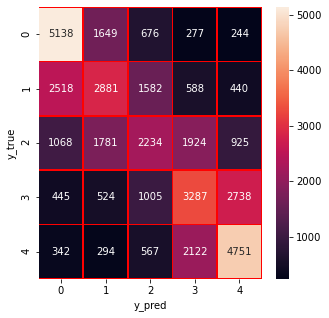

In [17]:
confusion(y_test,y_pred)

Imprimimos el valor para poder comparar con los siguientes modelos que vamos a entrenar cuando reduscamos la cantidad de variables a predecir

In [18]:
clf.score(X_test,y_test)

0.457275

Probamos con unos titulos basicos a ver como clasifica a mano

In [19]:
titulosdeprueba = [["muy malo",0],["malo",0],["bueno",0], ["medio malo",0],["excelente",0], ["si me sirvio para lo que es",0], ["Buen precio calidad",0]]

for titulo in titulosdeprueba:
    titulo[1]=clf.predict([titulo[0]])[0]

In [20]:
tabla_titulosdeprueba = pd.DataFrame(titulosdeprueba, columns = ["Review","Puntaje predicho"])

tabla_titulosdeprueba

,Review,Puntaje predicho
0,muy malo,1
1,malo,1
2,bueno,4
3,medio malo,2
4,excelente,5
5,si me sirvio para lo que es,2
6,Buen precio calidad,4


# Binarizacion del problema y reducción de error

En esta etapa buscaremos reducir el error y mejorar el score del modelo del anterior proyecto binarizando el problema. Para esto, en lugar de predecir un puntaje, predecirá si la review recomienda el producto o no.

In [21]:
#Separamos el dataset en 2
dataset.loc[dataset[dataset['stars']< 3].index,'recomendable']=0
dataset.loc[dataset[dataset['stars']>= 3].index,'recomendable']=1

Tomaremos que una review recomienda un producto cuando supuntaje sea mayor o igual a 3 estrellas

In [22]:
#paso valores a bool
dataset = dataset.astype({"recomendable": bool})

In [23]:
dataset

,stars,review_body,review_title,recomendable
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,False
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,False
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,False
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,False
4,1,Llega tarde y co la talla equivocada,Devuelto,False
...,...,...,...,...
199995,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,True
199996,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,True
199997,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,True
199998,5,Perfecto para el cumple de mi hijo,Recomendado,True


Entrenamos el modelo con los nuevos datos

In [24]:
X = dataset['review_title']
y = dataset['recomendable']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [26]:
clf_bin = Pipeline([('tfidf', tfidf), ('clf', classifier)])

In [27]:
clf_bin.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function token_cleaner at 0x000001EEC1511B80>)),
                ('clf', LinearSVC())])

In [28]:
from sklearn.metrics import confusion_matrix

y_pred = clf_bin.predict(X_test)

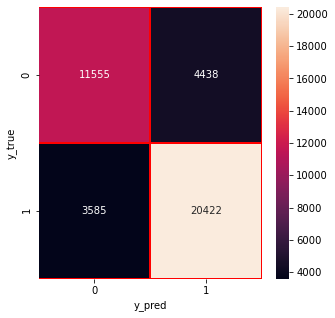

In [29]:
confusion(y_test,y_pred)

Ya viendo la matriz de confusión ya se ve una mejora pero veamos que dice el score

In [30]:
clf_bin.score(X_test,y_test)

0.799425

In [31]:
dataset.loc[dataset[dataset['stars']< 3].index,'recomendable'] = 0

In [32]:
dataset_bin = dataset.copy()

In [33]:
dataset_bin['recom_pred'] = clf_bin.predict(X)

In [34]:
dataset_bin

,stars,review_body,review_title,recomendable,recom_pred
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,0,True
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,0,False
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,0,True
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,0,False
4,1,Llega tarde y co la talla equivocada,Devuelto,0,False
...,...,...,...,...,...
199995,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,True,True
199996,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,True,True
199997,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,True,True
199998,5,Perfecto para el cumple de mi hijo,Recomendado,True,True


Graficamos como quedo la predicción de si las review recomiendan el producto o no

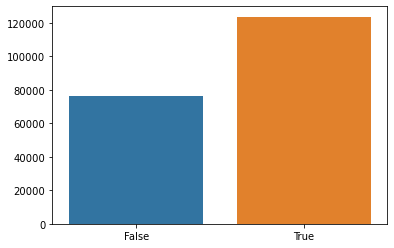

In [35]:
sns.barplot(dataset_bin['recom_pred'].value_counts().index,dataset_bin['recom_pred'].value_counts().values)
plt.show()

# Reviews negativas relacionadas con envio
<br>
Tambien nos preguntamos ¿Cuantas reviews de productos tienen un puntaje negativo debido a demoras o problemas ne la entrega del producto?

Usamos algoritmos <code>Word2Vec</code> y <code>FastText</code> para medir Word Mover’s Distance o <code>WMD</code>. Esto nos va a servir para obtener la distancia entre palabras u oraciones y distinguir cuales se refieren a entregas rapidas y lentas.

### Modelo FastText con sbwc

In [36]:
from gensim.models.keyedvectors import KeyedVectors
wordvectors_file_vec = 'fasttext-sbwc.3.6.e20.vec'
cantidad = 100000
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=cantidad)

In [37]:
wordvectors.most_similar_cosmul(positive=['demora'])#probamos palabras cercanas a demora

[('dilación', 0.900303065776825),
 ('tardanza', 0.8561467528343201),
 ('demoras', 0.8312034606933594),
 ('dilaciones', 0.8129552602767944),
 ('brevedad', 0.7981038689613342),
 ('oportunamente', 0.7812494039535522),
 ('retraso', 0.7800135016441345),
 ('prontitud', 0.7787097096443176),
 ('demore', 0.7551143169403076),
 ('demorado', 0.753860592842102)]

Probamos como funciona

In [38]:
#frases distintas
frase1="el paquete llego rapido"
frase2="hubo demora en el envio"

distancia = wordvectors.wmdistance(frase1, frase2)
print('Distancia = %.4f' % distancia)

Distancia = 1.6775


In [39]:
#Frases parecidas
frase1="el paquete llego con demora"
frase2="hubo demora en el envio"

distancia = wordvectors.wmdistance(frase1, frase2)
print('Distancia = %.4f' % distancia)

Distancia = 1.3969


A pesar de que el ultimo par de oraciones tiene una similitud el algoritmo lo marca como lejano

### Modelo w2v con sbwc

Probemos como se desempeña con W2V

In [40]:
SBW_vectors_file = 'SBW-vectors-300-min5.txt'

In [41]:
modelow2v = KeyedVectors.load_word2vec_format(SBW_vectors_file, limit=cantidad)

In [42]:
#frases distintas
frase1= "No han entregado el producto"
frase2= "el envio llego rapido"

distance = modelow2v.wmdistance(frase1, frase2)
print('distance = %.4f' % distance)

distance = 0.3834


In [43]:
#frases parecidas
frase1= "Plazo de envio no cumplido"
frase2= "hubo demora en el envio"

distance = modelow2v.wmdistance(frase1, frase2)
print('distance = %.4f' % distance)

distance = 0.3391


Como pueden ver, a pesar de que el corpus con el que se entrenó sea en español y el modelo está pre entrenado para funcionar en español los resultados distan de ser buenos para empezar a clasificar una review está relacionada con una entrega.
Sería interesante probar los resultados con un dataset en ingles, donde probablemente sea mejor el desempeño.

Por eso mismo probamos lemmatizando y haciendo busquedas tradicionales

### Identificar reviews negativas relacionadas con envio usando lemmatización
<br>
El objetivo sigue siendo encontrar las reviews que tienen mala puntuación y esté relacionada a la entrega del producto

Traemos las reviews que contengan la palabra <code>"entrega"</code> o <code>"envio"</code>

In [44]:
datasetprueba = dataset_bin[dataset_bin['review_title'].str.contains("entrega") | dataset_bin['review_title'].str.contains("envio")]
datasetprueba

,stars,review_body,review_title,recomendable,recom_pred
39,1,Una porqueria. Me lo han entregado roto. El em...,Porqueria de entrega,0,False
49,1,Pone que me lo han entregado hoy y o es verdad...,No entregado como pone,0,False
274,1,El envío se prometió para el 7 de dic y aún ho...,Plazo de envio no cumplido,0,False
301,1,No me llego este producto.,Sale entregado y no lo he recibido,0,False
324,1,Otra vez más la empresa Tourline Express se cu...,No han entregado el producto,0,False
...,...,...,...,...,...
198753,5,Muy buen producto todo muy bien envió rápido y...,Buen producto y envio rapido,True,True
198827,5,Producto de alta calidad con entrega lenta y m...,"Buen precio, entrega lenta",True,True
198876,5,producto de calidad y lo esperado,La entrega rapidisima,True,True
198910,5,"Me ha llegado un poco tarde, pero llegó un día...",Lentitud en envio,True,False


Podemos ver que el resultado es bastante bajo. ¿Que sucede si normalizamos y lemmatizamos?

In [49]:
dataset_review_lemma = [] #lista donde se van a guardar las reviews lemmatizadas
for titulo in dataset_bin.review_body:
    dataset_review_lemma.append(" ".join(token_cleaner(titulo)))

Hacemos las busqueda en base a palabras que estén relacionadas con la entrega y la demor del producto luego de lematizar.
<br>
Hay palabras que están incompletas para tambien se cuenten las conjugación de estas mismas que la lemmatización no pudo reducir.

In [54]:
palabras_clave = ["entreg","envi","lento","demora","tardar"]#lista de palabras 
dataset_envios_tarde = dataset_bin[(dataset_bin['review_title_lemma'].str.contains('|'.join(palabras_clave))) & (dataset_bin.recomendable==False)]
dataset_envios_tarde

,stars,review_body,review_title,recomendable,review_title_lemma,recom_pred
4,1,Llega tarde y co la talla equivocada,Devuelto,0,llega tardar co tallar equivocar,False
16,1,El producto tenía que llegar el 21 de septiemb...,Ojalá se acuerden,0,producto tener llegar septiembre aproximar no ...,True
26,1,"Lo siento, no puedo valorarlo, puesto que la a...",Pilar,0,sentir no poder valorarlo poner agenciar trans...,True
30,1,Ha tardado en llegar mucho más de lo esperado....,Se suponía que era un producto Prime....,0,tardar llegar mas esperar comprar pensar llega...,False
32,1,Me llego un correo diciendo que había llegado ...,No me ha llegado,0,llegar correar decir haber llegar paquete hace...,False
...,...,...,...,...,...,...
79975,2,muy rápido el envío y la instalación es muy fá...,no funciona la huella y uno de los cristales v...,0,muy rapido enviar instalacion ser muy facil ve...,False
79976,2,El producto excelente y el pedido en su fecha ...,Caja sin embalar,0,producto excelente pedir fecho entregar pegar ...,False
79985,2,Envían pilas de otra marca que no tiene que ve...,no son la marca anunciada,0,envian pilar marcar no tener ver foto publicar...,False
79988,2,Me tardo en llegar y encima estaba algo roto. ...,Me llego algo roto,0,tardar llegar encimar rotar puede ser puntual ...,False


El resultado encontrado fue casi 7 mayor una vez lematizados los <code>review_body</code> de cada review.
<br>
Lematizamos <code>review_body</code> ya que luego de pruebas daba mejores resultados que <code>review_titley</code>

Para poder visualizar un poco mejor vamos a graficar

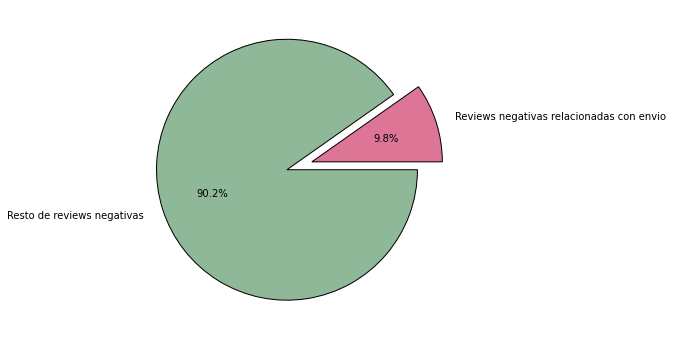

In [55]:
valores=[dataset_envios_tarde.shape[0],dataset_bin[dataset_bin["recomendable"]==0].shape[0]-dataset_envios_tarde.shape[0]
-dataset_envios_tarde.shape[0]]

colores = ['#DD7596', '#8EB897']# Colores para el grafico

ax = plt.subplots(figsize=[10,6])
plt.pie(valores,labels=["Reviews negativas relacionadas con envio","Resto de reviews negativas"],
        labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'black' }, colors=colores,
        explode=(0.2, 0),autopct="%.1f%%");

Encontramos aproximadamente 7119 (9% de las 200.000 reviews) reviews negativas que se relacionan con la entrega del producto.
<br>
Este dato puede servir para analizar y mejorar la distribución de los productos, reduciendo la cantidad de clientes insatisfechos.